# Ames Housing - Project Deliverable 3

---


**ACS-5513 - Applied Machine Learning**

**Dr. Neelam Dwivedi**

**Petabyte Pirates (Team A)**

**Source:** https://github.com/dewayneh57/ACS5513/blob/main/ACS-5113_Petabyte_Pirates_Deliverable_1.csv


## Initial Imports and Data Sourcing

In [12]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# options
pd.set_option("display.max_columns", None)

file_path_url_all = 'https://raw.githubusercontent.com/dewayneh57/ACS5513/main/data/ACS-5113_Petabyte_Pirates_Deliverable_2_ALL_FEATURES.csv'
file_path_url_final = 'https://raw.githubusercontent.com/dewayneh57/ACS5513/main/data/ACS-5113_Petabyte_Pirates_Deliverable_2_FINAL_MODEL.csv'

# Load the latest version with all features
df_all = pd.read_csv(file_path_url_all)
# Load the latest version with the final DataFrame
df = pd.read_csv(file_path_url_final)

print(df.shape)
df.head(20)

(2789, 30)


,Qual x SF Plus Garage + Garage Finish x Garage Area,Qual x SF Plus Garage,Qual x SF,Remodel Age,Gr Liv Area,Year Remod/Add,Total Bsmt SF,Total SF Plus Garage,Garage Yr Blt,House Age,Total SF,1st Flr SF,Fireplace Qu_Ord,Year Built,Kitchen Qual_Ord,Garage Finish x Garage Area,Garage Finish x Garage Area x Garage Cars,Garage Cars x Garage Area,Bsmt Qual_Ord,Garage Area,Heating QC_Ord,Total Baths,Overall Qual,Full Bath,Garage Finish x Garage Cars,Exter Qual_Ord,Garage Finish_Ord,House Style__2Story,Garage Cars,SalePrice
0,21168.0,19584.0,16416.0,50,1656,1960,1080.0,3264.0,1960.0,50,2736.0,1656,4.0,1960,3,1584.0,3168.0,1056.0,3.0,528.0,2,1.0,6,1,6.0,3,3.0,0,2.0,215000
1,13270.0,12540.0,8890.0,49,896,1961,882.0,2508.0,1961.0,49,1778.0,896,0.0,1961,3,730.0,730.0,730.0,3.0,730.0,3,1.0,5,1,1.0,3,1.0,0,1.0,105000
2,18132.0,17820.0,15948.0,52,1329,1958,1329.0,2970.0,1958.0,52,2658.0,1329,0.0,1958,4,312.0,312.0,312.0,3.0,312.0,3,1.5,6,1,1.0,3,1.0,0,1.0,172000
3,34760.0,33194.0,29540.0,42,2110,1968,2110.0,4742.0,1968.0,42,4220.0,2110,3.0,1968,5,1566.0,3132.0,1044.0,3.0,522.0,5,2.5,7,2,6.0,4,3.0,0,2.0,244000
4,16641.0,15195.0,12785.0,12,1629,1998,928.0,3039.0,1997.0,13,2557.0,928,3.0,1997,3,1446.0,2892.0,964.0,4.0,482.0,4,2.5,5,2,6.0,3,3.0,1,2.0,189900
5,19410.0,18000.0,15180.0,12,1604,1998,926.0,3000.0,1998.0,12,2530.0,926,4.0,1998,4,1410.0,2820.0,940.0,3.0,470.0,5,2.5,6,2,6.0,3,3.0,1,2.0,195500
6,27810.0,26064.0,21408.0,9,1338,2001,1338.0,3258.0,2001.0,9,2676.0,1338,0.0,2001,4,1746.0,3492.0,1164.0,4.0,582.0,5,2.0,8,2,6.0,4,3.0,0,2.0,213500
7,25540.0,24528.0,20480.0,18,1280,1992,1280.0,3066.0,1992.0,18,2560.0,1280,0.0,1992,4,1012.0,2024.0,1012.0,4.0,506.0,5,2.0,8,2,4.0,4,2.0,0,2.0,191500
8,31768.0,30552.0,25688.0,14,1616,1996,1595.0,3819.0,1995.0,15,3211.0,1616,3.0,1995,4,1216.0,2432.0,1216.0,4.0,608.0,5,2.0,8,2,4.0,4,2.0,0,2.0,236500
9,24006.0,22680.0,19586.0,11,1804,1999,994.0,3240.0,1999.0,11,2798.0,1028,3.0,1999,4,1326.0,2652.0,884.0,3.0,442.0,4,2.5,7,2,6.0,3,3.0,1,2.0,189000


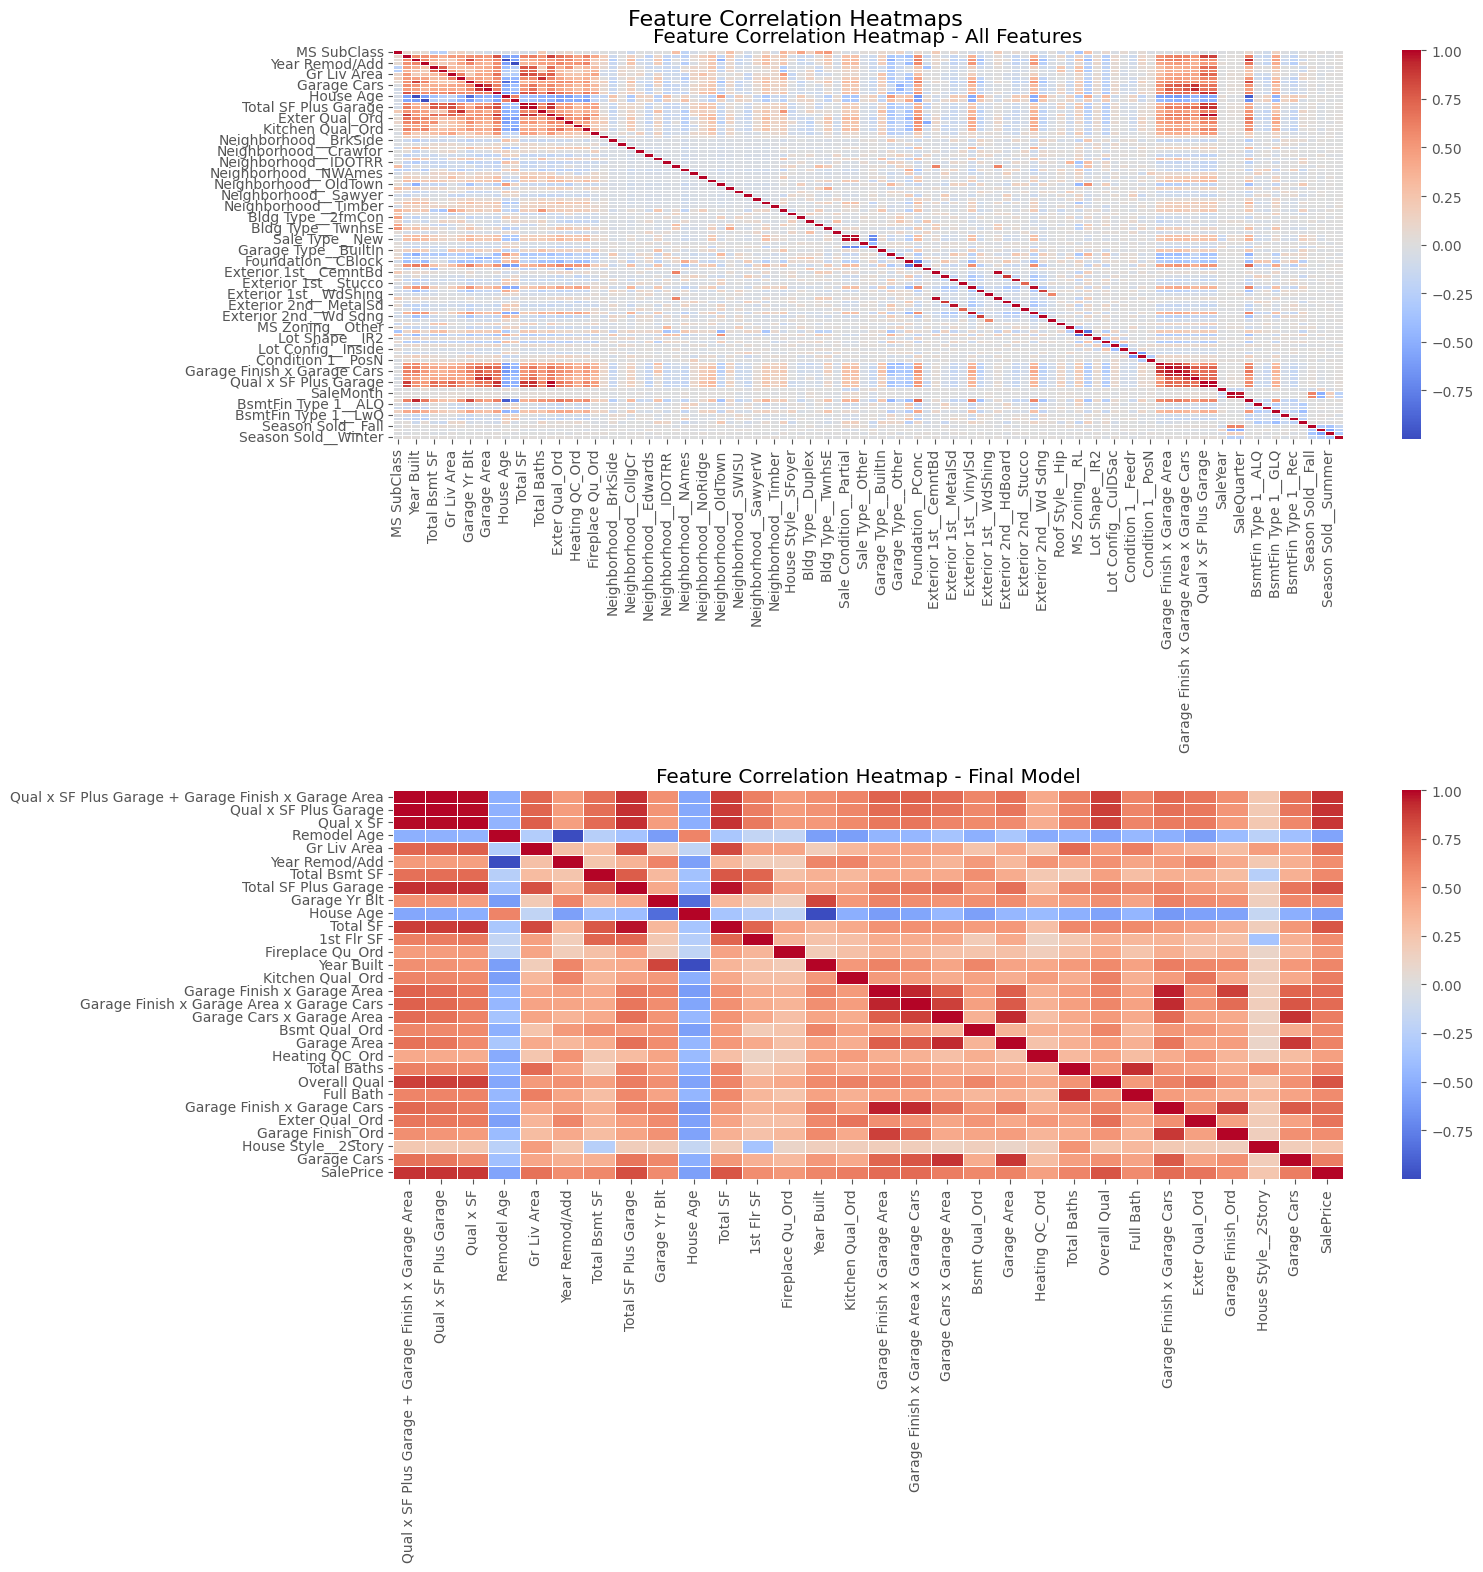

In [13]:
# feature correlation heatmap
import seaborn as sns, matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 16))

fig.suptitle('Feature Correlation Heatmaps', fontsize=16)

numeric_cols_all = df_all.select_dtypes(include=np.number).columns
corr_all = df_all[numeric_cols_all].corr()

numeric_cols = df.select_dtypes(include=np.number).columns
corr = df[numeric_cols].corr()

sns.heatmap(corr_all, cmap='coolwarm', center=0, linewidths=.5, ax=axes[0])
axes[0].set_title('Feature Correlation Heatmap - All Features')

sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=.5, ax=axes[1])
axes[1].set_title('Feature Correlation Heatmap - Final Model')

plt.tight_layout()
plt.show()

## Robust Catboost Model Tuning and Evaluation

Performing, visualizing, and interpretating important evaluation metrics

In [14]:
# Imports
!pip install -q catboost shap optuna

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from catboost import CatBoostRegressor, Pool, cv
import shap, optuna, warnings, json, os, joblib

warnings.filterwarnings("ignore")
plt.style.use("ggplot")

In [15]:
df_model = df.copy()

X = df_model.drop('SalePrice', axis=1)
y = df_model['SalePrice']

train_X, test_X, train_y, test_y = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Optuna hyper-param search
from catboost import cv, Pool, CatBoostRegressor
import optuna, numpy as np, pandas as pd, joblib, json

train_pool = Pool(train_X, train_y)

def objective(trial):
    params = {
        "loss_function": "RMSE",
        "eval_metric":   "RMSE",
        "iterations":    trial.suggest_int ("iterations",    300, 1200),
        "learning_rate": trial.suggest_float("learning_rate",0.02, 0.3, log=True),
        "depth":         trial.suggest_int ("depth",          4, 10),
        "l2_leaf_reg":   trial.suggest_float("l2_leaf_reg",   1, 10, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
        "random_seed":   42,
        "early_stopping_rounds": 100,
        "verbose": False,
    }
    cv_res = cv(train_pool, params, fold_count=5, verbose=False)
    return cv_res["test-RMSE-mean"].min()

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, show_progress_bar=True)
best_params = study.best_trial.params
print("Best params:", json.dumps(best_params, indent=2))

# Training tuned Catboost model
best_cb = CatBoostRegressor(**best_params, loss_function="RMSE",
                            random_seed=42, verbose=False,
                            early_stopping_rounds=150)
best_cb.fit(train_X, train_y, eval_set=(test_X, test_y))

preds = best_cb.predict(test_X)
rmse = np.sqrt(mean_squared_error(test_y, preds))
r2   = r2_score(test_y, preds)
med  = np.median(np.abs((test_y - preds)/test_y))*100

print(f"RMSE  : ${rmse:,.0f}")
print(f"R²    : {r2:.3f}")
print(f"Median % Error: {med:.2f}%")

joblib.dump(best_cb, "catboost_tuned.pkl")

[I 2025-08-01 01:18:36,438] A new study created in memory with name: no-name-d7b27202-f2d4-4482-8a3a-dae65611f3f5


  0%|          | 0/50 [00:00<?, ?it/s]

Training on fold [0/5]

bestTest = 22630.39536
bestIteration = 355

Training on fold [1/5]

bestTest = 20597.06022
bestIteration = 305

Training on fold [2/5]

bestTest = 20234.55987
bestIteration = 360

Training on fold [3/5]

bestTest = 19547.5352
bestIteration = 243

Training on fold [4/5]

bestTest = 21012.21897
bestIteration = 424

[I 2025-08-01 01:18:51,998] Trial 0 finished with value: 20841.744426319634 and parameters: {'iterations': 748, 'learning_rate': 0.07996096239126174, 'depth': 4, 'l2_leaf_reg': 4.4750003200611905, 'bagging_temperature': 0.42283625895055776}. Best is trial 0 with value: 20841.744426319634.
Training on fold [0/5]

bestTest = 22678.96742
bestIteration = 92

Training on fold [1/5]

bestTest = 21124.71129
bestIteration = 212

Training on fold [2/5]

bestTest = 21032.12647
bestIteration = 129

Training on fold [3/5]

bestTest = 20096.39831
bestIteration = 166

Training on fold [4/5]

bestTest = 20892.58417
bestIteration = 105

[I 2025-08-01 01:18:59,493] Tria

['catboost_tuned.pkl']

In [16]:
# Run with tuned hyper-parameters
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=True
)

cat = CatBoostRegressor(
    iterations=1037,
    learning_rate=0.027132395292861496,
    depth=5,
    l2_leaf_reg=1.4404938199025161,
    bagging_temperature=0.5159096827176125,
    loss_function='RMSE',
    random_seed=42,
    verbose=False
)

cat.fit(X_train, y_train)

y_pred = cat.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

pct_errors = (y_pred - y_test) / y_test
abs_pct_errors = np.abs(pct_errors)

median_pct_error = np.median(abs_pct_errors) * 100   # as %
within_5   = (abs_pct_errors <= 0.05).mean() * 100   # %
within_10  = (abs_pct_errors <= 0.10).mean() * 100   # %

# Results
print(f"\nFinal Tuned Catboost Results\n" + "-"*33)
print(f"RMSE                 : ${rmse:,.0f}")
print(f"R²                   : {r2:0.3f}")
print(f"Median % Error       : {median_pct_error:0.2f}%")
print(f"Within ±5 % of price : {within_5 :0.2f}% of homes")
print(f"Within ±10 % of price: {within_10:0.2f}% of homes")



Final Tuned Catboost Results
---------------------------------
RMSE                 : $20,708
R²                   : 0.888
Median % Error       : 6.38%
Within ±5 % of price : 41.94% of homes
Within ±10 % of price: 68.64% of homes


In [19]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_rmse, fold_r2 = [], []

for i,(tr,vl) in enumerate(kf.split(train_X)):
    cb = CatBoostRegressor(**best_params, verbose=False, random_seed=42)
    cb.fit(Pool(train_X.iloc[tr], train_y.iloc[tr]),
           eval_set=Pool(train_X.iloc[vl], train_y.iloc[vl]))
    p = cb.predict(train_X.iloc[vl])
    fold_rmse.append(np.sqrt(mean_squared_error(train_y.iloc[vl], p)))
    fold_r2.append(r2_score(train_y.iloc[vl], p))
    print(f"Fold {i+1}: RMSE {fold_rmse[-1]:,.0f}, R² {fold_r2[-1]:.3f}")

print(f"\nCV RMSE mean ± std : {np.mean(fold_rmse):,.0f} ± {np.std(fold_rmse):,.0f}")
print(f"CV R²   mean ± std : {np.mean(fold_r2):.3f} ± {np.std(fold_r2):.3f}")

Fold 1: RMSE 20,614, R² 0.871
Fold 2: RMSE 19,428, R² 0.875
Fold 3: RMSE 20,638, R² 0.881
Fold 4: RMSE 22,380, R² 0.849
Fold 5: RMSE 19,945, R² 0.891

CV RMSE mean ± std : 20,601 ± 997
CV R²   mean ± std : 0.873 ± 0.014


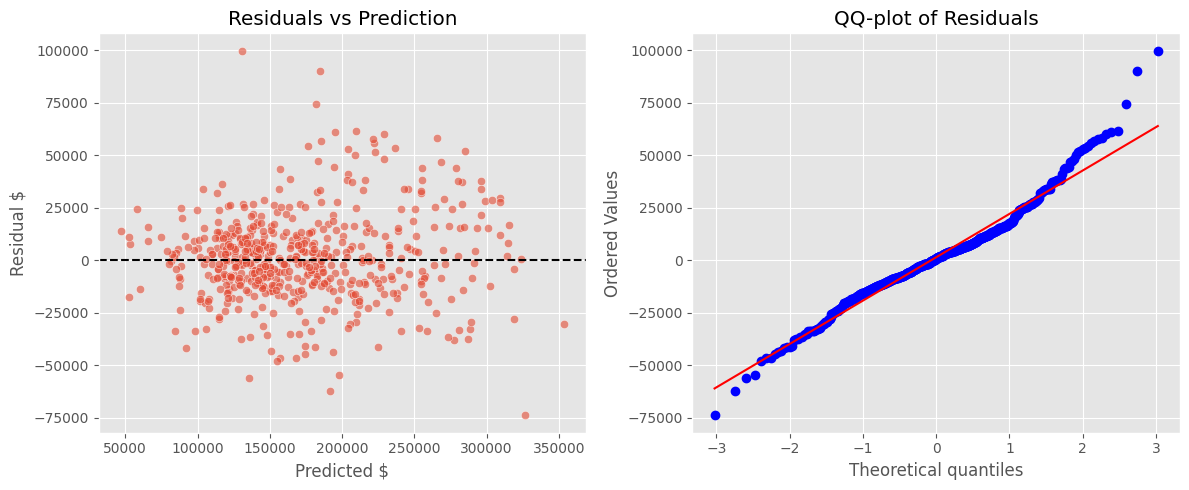

In [20]:
fig,ax=plt.subplots(1,2,figsize=(12,5))

# Residuals vs Predicted
res = test_y - preds
sns.scatterplot(x=preds, y=res, ax=ax[0], alpha=.6)
ax[0].axhline(0, ls='--', c='black')
ax[0].set_xlabel("Predicted $"); ax[0].set_ylabel("Residual $");
ax[0].set_title("Residuals vs Prediction")

# QQ plot
import scipy.stats as st
st.probplot(res, dist="norm", plot=ax[1])
ax[1].set_title("QQ-plot of Residuals")

plt.tight_layout(); plt.show()

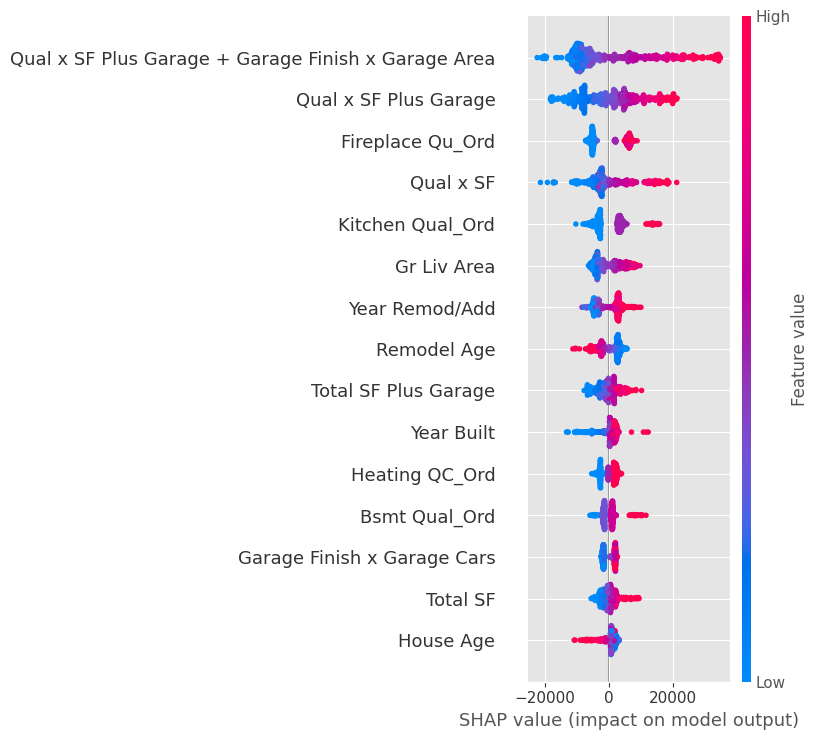

In [22]:
explainer  = shap.TreeExplainer(best_cb)
shap_vals  = explainer.shap_values(test_X)

# Global
shap.summary_plot(shap_vals, test_X, plot_type="bar", show=False)
plt.tight_layout(); plt.savefig("shap_global.png"); plt.close()

shap.summary_plot(shap_vals, test_X, max_display=15)
plt.tight_layout(); plt.savefig("shap_summary.png"); plt.close()